In [1]:
from utils.data_loading import CombustionSystemDataset

PATH = 'Zare_data/combustion_img_13.mat'

test_data = CombustionSystemDataset(PATH,'test_set_x','test_set_y')
train_data = CombustionSystemDataset(PATH,'train_set_x','train_set_y')

In [2]:
index = 200
image = test_data.data[index]
label = test_data.labels[index]

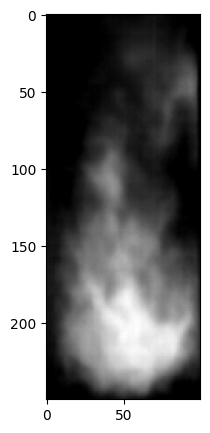

In [3]:
import numpy as np
import matplotlib.pyplot as plt

test_image = np.resize(image,(250,100))
plt.figure(figsize=(20,5))
plt.imshow(test_image, cmap='gray')
plt.show()

In [4]:
from torch.utils.data import DataLoader,random_split
test_dataloader = DataLoader(test_data, batch_size=512, shuffle=True)
train_dataloader = DataLoader(train_data, batch_size=512, shuffle=True)

In [5]:
import itertools
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transformers
import matplotlib.pyplot as plt

In [6]:
class Encoder(nn.Module):
    def __init__(self, bottleneck_size):
        super(Encoder,self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(5,3), stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32,out_channels=64, kernel_size=(5,3), stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,out_channels=128, kernel_size=3,stride=2, padding=0),
            nn.ReLU()
        )

        self.dense_layers = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(128 * 30* 12 , 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512,bottleneck_size),
           )
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.dense_layers(x)
        return x


In [7]:
class Decoder(nn.Module):
    def __init__(self, bottleneck_size ):
        super(Decoder,self).__init__()
        self.conv_layers = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64,out_channels=32, kernel_size=(5,3), stride=2, padding=1, output_padding=(1,0)),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32,out_channels=1, kernel_size=(5,3),stride=2, padding=1, output_padding=1),
            nn.ReLU()
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(128,30,12))

        self.dense_layers = nn.Sequential(

            nn.Linear(bottleneck_size,1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 128 * 30 * 12),
            nn.ReLU(),
            nn.Dropout(0.2),
           )

    def forward(self, x):
        x = self.dense_layers(x)
        x  = self.unflatten(x)
        x = self.conv_layers(x)
        x = x[:, :, 4:254, 2:102]

        return x


In [8]:
class AE(nn.Module):

    def __init__(self, encoder, decoder, bottleneck_size=1024):
        super(AE,self).__init__()
        self.encoder = encoder(bottleneck_size)
        self.decoder = decoder(bottleneck_size)
    def forward(self,x ):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



In [11]:
import torch
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AE(Encoder, Decoder)
model.to(device)  # Move the model to the GPU

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 512
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)


def training(model, criterion, optimizer, train_loader, test_loader, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        model.train()
        batch_train_loss = []
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move inputs and targets to the GPU
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            batch_train_loss.append(loss.item())
            loss.backward()
            optimizer.step()

        model.eval()
        batch_test_loss = []
        for test_inputs, test_targets in test_loader:
            test_inputs, test_targets = test_inputs.to(device), test_targets.to(device)  # Move test inputs and targets to the GPU
            test_outputs = model(test_inputs)
            loss = criterion(test_outputs, test_inputs)
            batch_test_loss.append(loss.item())

        train_loss = np.mean(batch_train_loss)
        test_loss = np.mean(batch_test_loss)

        train_losses[it] = train_loss
        test_losses[it] = test_loss

        if (it + 1) % 2 == 0:
            print(f'Epoch {it + 1}/{epochs}, Loss_train: {train_loss:.4f}, Loss_test: {test_loss:.4f}')

    return train_losses, test_losses

train_losses, test_losses = training(model, criterion, optimizer, train_loader, test_loader, 10)


Epoch 2/10, Loss_train: 1996.0160, Loss_test: 1177.2520
Epoch 4/10, Loss_train: 636.0489, Loss_test: 977.1533
Epoch 6/10, Loss_train: 561.1061, Loss_test: 708.7181
Epoch 8/10, Loss_train: 530.5947, Loss_test: 843.8753
Epoch 10/10, Loss_train: 503.9372, Loss_test: 937.7373


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

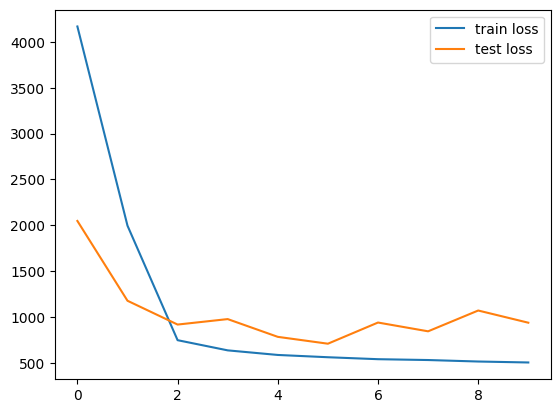

In [12]:
plt.plot(train_losses,label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.show()

In [20]:
model.to('cpu')
for images, target in test_loader:
   output =  model(images)
   break

In [28]:
con_image = output.detach().numpy()[20]
ri_image = images.detach().numpy()[20]

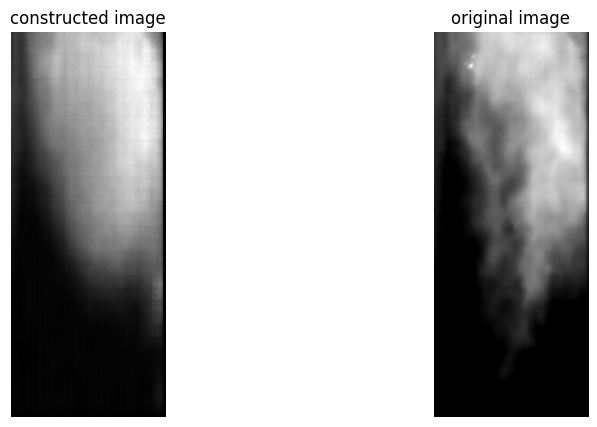

In [29]:
import matplotlib.pyplot as plt

# Assuming con_image[0] and con_image[1] are the images you want to display
image1 = con_image[0]
image2 = ri_image[0]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Create a 1x2 grid of subplots
axes[0].imshow(image1, cmap='gray')
axes[0].set_title('constructed image')  # Replace 'Label 1' with the desired label for the first image
axes[0].axis('off')

axes[1].imshow(image2, cmap='gray')
axes[1].set_title('original image')  # Replace 'Label 2' with the desired label for the second image
axes[1].axis('off')

plt.show()


In [24]:
torch.save(model.state_dict(), './logging/model.pth')